# Assignment 1

Each question is solved in that notebook and can be reproduced after installing the environment.

## import packages

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-03-18 17:59:30--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  12.2MB/s    in 14s     

2022-03-18 17:59:45 (11.7 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [2]:
! tar xzvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
! pip install scikit-learn-intelex
! pip install scikit-image
! pip install joblib

In [4]:
from sklearnex import patch_sklearn
patch_sklearn()
# enable sklearnx accelerated version by intel
from skimage import data, exposure
from skimage import exposure
from skimage.feature import hog
from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import os
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.autograd import Variable
import torchvision.transforms as trns
from PIL import Image, ImageOps
from joblib import Parallel, delayed
from typing import Any, Callable, Optional, Tuple
from numpy.fft import fft2, ifft2
import time
import copy
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import AdaptiveAvgPool2d
from pylab import *
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets.vision import VisionDataset

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## utils
some useful functions

In [5]:

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [6]:
def show_image(image_list: list, label_list:list, classes: list, number: int = 5):
    # generate a random number set to show image
    fig, axs = plt.subplots(
        1, number, figsize=(4, 4), sharex=True, sharey=True)
    

    
    for i, idx in enumerate(np.random.randint(0, len(image_list), number)):
        axs[i].axis('off')
        axs[i].imshow(image_list[idx], cmap=plt.cm.gray)
        axs[i].set_title(classes[label_list[idx]])

        

    plt.show()


In [7]:
get_num_correct = lambda preds, labels: preds.argmax(dim=1).eq(labels).sum().item()

## Question 1 Reading & Preparing Image Data

In [8]:
image_reconstruction = lambda x: Image.fromarray(
x.reshape(3, 32, 32).transpose(1, 2, 0), 'RGB')


In [9]:
batch_meta = unpickle("cifar-10-batches-py/batches.meta")

data_batch_list = []
for x in range(1, 6):
    eval(
        "data_batch_list.append(unpickle('cifar-10-batches-py/data_batch_{x}'))".format(x=x))
test_batch = unpickle("cifar-10-batches-py/test_batch")
data_train = {"label": [], "image": []}
data_validate = {"label": [], "image": []}
for batch in data_batch_list:
    data_train["label"].extend(batch[b"labels"])
    data_train["image"].extend([image_reconstruction(raw_data)
                               for raw_data in batch[b"data"]])

data_validate["label"].extend(test_batch[b"labels"])
data_validate["image"].extend([image_reconstruction(
    raw_data) for raw_data in test_batch[b"data"]])

classes = [c.decode() for c in batch_meta[b"label_names"]]


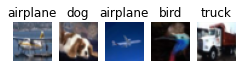

In [10]:
show_image(data_train["image"], data_train['label'], classes)


The answer to the **question 1** is shown above.

## Question 2 Data augmentation

In [11]:
data_augmentation_transform = trns.Compose([
    trns.RandomRotation(30),
    trns.RandomResizedCrop(32, scale=(0.8, 1.1), ratio=(1.0, 1.0)),
    trns.RandomHorizontalFlip(),
])

train_transform = trns.Compose([
    data_augmentation_transform,
    trns.ToTensor(),
    trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = trns.Compose([
    trns.ToTensor(),
    trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
def show_data_augmentation(image_list, number: int = 5):
    for i in np.random.randint(0, len(image_list), number):
        data_augmentation_transform(image_list[i]).show()


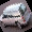

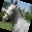

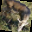

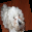

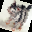

In [13]:
show_data_augmentation(data_train['image'])


We craete a sequence of transformation called `data_augmentation_transform` to do the following augmentation:
- Random Image Rotation
- Random Resized ans Crop
- Random Horizontal Flip

And the results is shown above.

## Question 3 Features Extraction

### scikit-learn HOG process

In [14]:
data_train["hog_raw"] = Parallel(n_jobs=16)(delayed(lambda x: hog(x, orientations=9, pixels_per_cell=(8, 8),
                                                                  cells_per_block=(2, 2), visualize=True, multichannel=True))(img) for img in data_train['image'])
data_validate["hog_raw"] = Parallel(n_jobs=16)(delayed(lambda x: hog(x, orientations=9, pixels_per_cell=(8, 8),
                                                                     cells_per_block=(2, 2), visualize=True, multichannel=True))(img) for img in data_validate['image'])
# just using joblib to speed up the process with multithreading
data_train["hog"] = [d[0] for d in data_train["hog_raw"]]
data_train["hog_img"] = [d[1] for d in data_train["hog_raw"]]
data_validate["hog"] = [d[0] for d in data_validate["hog_raw"]]
data_validate["hog_img"] = [d[1] for d in data_validate["hog_raw"]]


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Using joblib to parallel the hog function seeing that the hog is too slow.

### Hand writing HOG

In [15]:
def np_fftconvolve(A, B):
    return np.real(ifft2(fft2(A)*fft2(B, s=A.shape)))

The above is a two-dimensional convolution function implemented by `fft`.

In [16]:
def angle_to_bin(angle):
    if angle >= 170 or angle < 10:
        return 0
    elif angle < 30:
        return 1
    elif angle < 50:
        return 2
    elif angle < 70:
        return 3
    elif angle < 90:
        return 4
    elif angle < 110:
        return 5
    elif angle < 130:
        return 6
    elif angle < 150:
        return 7
    elif angle < 170:
        return 8

This function is convert the angle into the classification of bins.

In [17]:
def split_matrix(M, s): return M.reshape(
    (-1, s, M.shape[1]//s, s)).transpose((0, 2, 1, 3)).reshape(M.shape[1]//s, M.shape[1]//s, s*s)


This function is split matrix into smaller ones like:

$$
\begin{pmatrix}

0 & 1 & 2 & 3 \\
4 & 5 & 6 & 7 \\
8 & 9 & 10 & 11 \\
12 & 13 & 14 & 15 \\


\end{pmatrix}

\to

\begin{pmatrix}

\begin{pmatrix}
 0 & 1 \\
 4 & 5 \\
\end{pmatrix}

& \begin{pmatrix}
 2 & 3 \\
 6 & 7 \\
\end{pmatrix}
 \\
\begin{pmatrix}
 8 & 9 \\
 12 & 13 \\
\end{pmatrix}
& \begin{pmatrix}
 10 & 11 \\
 14 & 15 \\
\end{pmatrix}

\end{pmatrix} 


\to 

\begin{pmatrix}

\begin{pmatrix}
 0 & 1 &
 4 & 5 \\
\end{pmatrix}

& \begin{pmatrix}
 2 & 3 &
 6 & 7 \\
\end{pmatrix}
 \\
\begin{pmatrix}
 8 & 9 &
 12 & 13 \\
\end{pmatrix}
& \begin{pmatrix}
 10 & 11 &
 14 & 15 \\
\end{pmatrix}

\end{pmatrix} 

$$

In [18]:
def filter_image(im, filtr):
    filtr = np.flip(filtr)
    return np_fftconvolve(im, filtr)

just filte the image to get the graded image by the filter.

In [19]:
def get_gradient(im_dx, im_dy):
    x_squared = np.square(im_dx)
    y_squared = np.square(im_dy)
    grad_mag = np.sqrt(np.add(x_squared, y_squared))
    grad_angle = np.arctan2(im_dy, im_dx)
    return grad_mag, grad_angle

Calculate the magnitude gradient and the angle gradient

In [20]:
def build_histogram(grad_mag, grad_angle, cell_size):
    M = grad_mag.shape[0]//cell_size
    N = grad_mag.shape[1]//cell_size
    hist = np.zeros((M, N, 9))

    drg_grad_angle = np.abs(grad_angle*180/np.pi)
    vector_angle_to_bin = np.vectorize(angle_to_bin)
    bin_grad = vector_angle_to_bin(drg_grad_angle)
    
    for i in range(9):
        grad_mag_bin = (bin_grad == i).astype(int) * grad_mag
        grad_mag_bin = split_matrix(grad_mag_bin, cell_size)
        grad_mag_bin = np.sum(grad_mag_bin, axis=2)
        hist[:, :, i] = grad_mag_bin

    return hist

get the histogram of each cell using the grad angle and magnitude.

In [21]:
def get_block_descriptor(ori_histo):
    ori_histo_normalized = np.zeros(ori_histo.shape)
    for i in range(ori_histo.shape[0]):
        for j in range(ori_histo.shape[1]):
            block = ori_histo[i, j]
            ori_histo_normalized[i, j] = block / np.sqrt(np.sum(block ** 2) + np.e ** 2)
    return ori_histo_normalized

noramlize the histogram.

In [22]:
def extract_hog(im):
    im = im.astype('float') / 255.0
    diff_filter_x = np.array(
        [[1.0, 0.0, -1.0], [1.0, 0.0, -1.0], [1.0, 0.0, -1.0]])
    diff_filter_y = np.array(
        [[1.0, 1.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -1.0, -1.0]])

    diff_x = filter_image(im, diff_filter_x)
    diff_y = filter_image(im, diff_filter_y)
    grad_mag, grad_angle = get_gradient(diff_x, diff_y)

    block_size = 1
    cell_size = 8

    histogram = build_histogram(grad_mag, grad_angle, cell_size)

    descriptor = get_block_descriptor(histogram)

    hog = descriptor.reshape(descriptor.shape[0] * descriptor.shape[1], descriptor.shape[2])
    return hog

Assemble the above functions.

1. calculate the get differential images on x direction and y direction by imply Sobel filter.
2. calculate the gradients magnitudes and gradients angles.
3. create histogram for every cell.
4. normalize on every cell.

In [23]:
def show_hog_image():
    rnd = np.random.randint(0, len(data_train['image']))
    img = data_train['image'][rnd]
    label = data_train['label'][rnd]
    hog_img = data_train['hog_img'][rnd]
    
    grap_img = np.array(ImageOps.grayscale(img))
    hog = extract_hog(grap_img)
    num_bins = 9
    max_len = 10
    cell_size = 8
    im_h, im_w = grap_img.shape
    num_cell_h, num_cell_w = im_h // cell_size, im_w // cell_size
    num_blocks_h, num_blocks_w = num_cell_h, num_cell_w
    histo_normalized = hog.reshape(
        (num_blocks_h, num_blocks_w, 1, num_bins))
    
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size//2: cell_size*num_cell_w-cell_size/2+1: cell_size], np.r_[
                                 cell_size//2: cell_size*num_cell_h-cell_size/2+1: cell_size])
    
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))
    
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))


    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(3, 3), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_title(classes[label])

    ax2.axis('off')
    ax2.imshow(hog_img, cmap=plt.cm.gray)
    ax2.set_title('sk-HOG')

    ax3.imshow(grap_img.astype('float')/255.0, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        ax3.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.005, angles='xy')
    ax3.set_title('hw-HOG')

    plt.show()


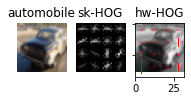

In [24]:
show_hog_image()

The answer to *Question 3* is shown above. `sk-HOG` is implied by `sk-image`, `hw-HOG` is implied by hand write.

## Question 4 SVM classification

### create PCA data set

In [25]:
pac = PCA(n_components=64)
data_train['hog_pca'] = pac.fit_transform(data_train['hog'])
data_validate['hog_pca'] = pac.transform(data_validate['hog'])


Using `skcit-learn`'s `PCA` to get principal component.

### sklearn vision

In [101]:
%%time
svm_model = svm.LinearSVC(loss='hinge', C=0.01, max_iter=10000)
svm_model.fit(data_train['hog'], data_train['label'])
prediction = svm_model.predict(data_validate['hog'])
print(accuracy_score(data_validate['label'], prediction))


0.4345
CPU times: user 18.5 s, sys: 754 ms, total: 19.2 s
Wall time: 18.3 s


The accuay_score of `skcit-learn`'s `svm` using `hinge` without `PCA` is shown above.

#### with PCA

In [102]:
%%time
svm_pca_model = svm.LinearSVC(loss='hinge', C=0.01, max_iter=10000)
svm_pca_model.fit(data_train['hog_pca'], data_train['label'])
prediction = svm_pca_model.predict(data_validate['hog_pca'])
print(accuracy_score(data_validate['label'], prediction))


0.397
CPU times: user 1.43 s, sys: 196 ms, total: 1.62 s
Wall time: 1.38 s


The accuay_score of `skcit-learn`'s `svm` using `hinge` with `PCA` is shown above.

The `SVM-without-PCA` gives a better accuracy than `SVM-with-PCA`, but `SVM-with-PAC` cost less time which is more efficient.

### pytorch vision

#### dataset and dataloader

In [28]:
class cifar10_hog(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx])
        return {'data': data, 'label': label}

batch_size_svm = 256

cifar10_dataset_train = cifar10_hog(data_train['hog'], data_train['label'])
cifar10_dataset_validate = cifar10_hog(
    data_validate['hog'], data_validate['label'])
cifar10_pca_dataset_train = cifar10_hog(
    data_train['hog_pca'], data_train['label'])
cifar10_pca_dataset_validate = cifar10_hog(
    data_validate['hog_pca'], data_validate['label'])

cifar10_dataloader_train = torch.utils.data.DataLoader(
    cifar10_dataset_train, batch_size=batch_size_svm, shuffle=True)
cifar10_dataloader_validate = torch.utils.data.DataLoader(
    cifar10_dataset_validate, batch_size=batch_size_svm, shuffle=True)
cifar10_pca_dataloader_train = torch.utils.data.DataLoader(
    cifar10_pca_dataset_train, batch_size=batch_size_svm, shuffle=True)
cifar10_pca_dataloader_validate = torch.utils.data.DataLoader(
    cifar10_pca_dataset_validate, batch_size=batch_size_svm, shuffle=True)


#### loss function

In [29]:
class multiClassHingeLoss(nn.Module):
    def __init__(self, p=1, margin=1, weight=None, size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.p=p
        self.margin=margin
        self.weight=weight
        self.size_average=size_average
    def forward(self, output, y):

        output_y=output[torch.arange(0,y.size()[0]).long().cuda(),y.data.cuda()].view(-1,1)
        loss=output-output_y+self.margin
        
        loss[torch.arange(0,y.size()[0]).long().cuda(),y.data.cuda()]=0
       
        loss[loss<0]=0
        
        if(self.p!=1):
            loss=torch.pow(loss,self.p)
        
        if(self.weight is not None):
            loss=loss*self.weight
        
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]
        return loss

$$
loss(x,y) = \sum_{ij}{\frac{max(0, 1 - (x[y[j]]-x[i]))}{x.size(0)}}
$$

In [98]:
loss = multiClassHingeLoss()
x = torch.FloatTensor([[0.1, 0.2, 0.4, 0.8]])
y = torch.LongTensor([[3, 0, -1, 1]])
loss(x, y)

tensor(12.7000)

#### model

In [94]:
epoch_num = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nn.Linear(data_train['hog'][0].shape[0], len(classes)).to(device)
model_pca = nn.Linear(data_train['hog_pca']
                      [0].shape[0], len(classes)).to(device)


The whole `SVM` is just a `Linear` layer.

#### training function

In [95]:
from sklearn.metrics import f1_score


def svm_train(svm_dataloader_train, svm_dataloader_validate, model):
    best_acc = 0.0
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    lr_schduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = multiClassHingeLoss()
    
    comment = f'-svm'
    tb = SummaryWriter(comment=comment)
    for epoch in range(epoch_num):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_loop = tqdm(svm_dataloader_train)
        for data in train_loop:
            inputs, labels = data['data'], data['label']
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_acc += get_num_correct(outputs, labels)
            train_loop.set_description(f'Epoch {epoch+1}/{epoch_num}')
            train_loop.set_postfix(loss=loss.item(
            ), acc=train_acc/(len(svm_dataloader_train)*svm_dataloader_train.batch_size))
        lr_schduler.step()
        train_loss /= len(svm_dataloader_train)
        train_acc /= len(svm_dataloader_train) * \
            svm_dataloader_train.batch_size
        tb.add_scalar('train_loss', train_loss, epoch)
        tb.add_scalar('train_acc', train_acc, epoch)
        model.eval()
        validate_acc = 0.0
        with torch.no_grad():
            for i, data in enumerate(svm_dataloader_validate):
                inputs, labels = data['data'], data['label']
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    validate_acc += get_num_correct(outputs, labels)
            validate_acc /= len(svm_dataloader_validate) * \
                svm_dataloader_validate.batch_size
            best_acc = max(best_acc, validate_acc)
        tb.add_scalar('validate_acc', validate_acc, epoch)
        tb.add_scalar('best_acc', best_acc, epoch)

    print('best acc:', best_acc)


We put fetures into the `SVM` which is a linear layer for each batch and calculate the `Hinge` loss, then we use the `SGD` optimizer to backward the `SVM`.

#### start training

##### without PCA

In [96]:
svm_train(cifar10_dataloader_train, cifar10_dataloader_validate, model)

Epoch 15/15: 100%|██████████| 196/196 [00:01<00:00, 125.33it/s, acc=0.457, loss=4.27]


best acc: 0.43974609375


##### with PCA

In [34]:
svm_train(cifar10_pca_dataloader_train,
          cifar10_pca_dataloader_validate, model_pca)


Epoch 15/15: 100%|██████████| 196/196 [00:01<00:00, 143.44it/s, acc=0.452, loss=3.89]


best acc: 0.4365234375


The `SVM-without-PCA` gives a better accuracy than `SVM-with-PCA`, but `SVM-with-PAC` cost less time which is more efficient.


## Question 5 Training your own CNN models

### Construct Dataset and Dataloader

In [35]:
class CIFAR10(VisionDataset):
    base_folder = 'cifar-10-batches-py'
    train_list = ['data_batch_1', 'data_batch_2',
                  'data_batch_3', 'data_batch_4', 'data_batch_5']

    test_list = ['test_batch']
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
    }

    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
    ) -> None:

        super(CIFAR10, self).__init__(root, transform=transform,
                                      target_transform=target_transform)

        self.train = train

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        for file_name in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))
        self._load_meta()

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])

        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i,
                             _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)


The `CIFAR10` dataset creater.

In [36]:
cifar10_dataset_train = CIFAR10(
    root='./', train=True, transform=train_transform)
cifar10_dataset_validate = CIFAR10(
    root='./', train=False, transform=valid_transform)

Instantiation the train dataset and validation dataset.

In [37]:
batch_size = 256
valid_size = 0.5

num_test = len(cifar10_dataset_validate)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
test_idx, valid_idx = indices[split:], indices[:split]

valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    cifar10_dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(
    cifar10_dataset_validate, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(
    cifar10_dataset_validate, batch_size=batch_size, sampler=test_sampler, num_workers=1)
visualize_loader = torch.utils.data.DataLoader(
    cifar10_dataset_validate, batch_size=1, num_workers=1, shuffle=False)


Create torch Dataloader.

### train function

In [38]:
def train(model, name, num_epochs=30):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=5, verbose=True)

    comment = f'-{name}'
    tb = SummaryWriter(log_dir='./logs',comment=comment)

    valid_loss_min = np.Inf
    # num_epochs = 30

    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0

        train_loop = tqdm(train_loader)
        model.train()
        for batch in train_loop:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_acc += get_num_correct(preds, labels) 

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{num_epochs}]')
            train_loop.set_postfix(loss=loss.item(), acc=train_acc/len(cifar10_dataset_train))


        tb.add_scalar('Train Loss', train_loss, epoch)
        tb.add_scalar('Train Accuracy', train_acc/len(cifar10_dataset_train), epoch)

        model.eval() 
        with torch.no_grad():  
            valid_loss, valid_correct = 0, 0  

            for batch in valid_loader:
                images, labels = batch[0].to(device), batch[1].to(device)  
                preds = model(images) 
                loss = criterion(preds, labels) 

                valid_loss += loss.item() * labels.size(0) 
                valid_correct += get_num_correct(preds, labels) 



            tb.add_scalar('Validation Loss', valid_loss, epoch)
            tb.add_scalar('Validation Accuracy', valid_correct/len(valid_loader.sampler), epoch)

            train_loss = train_loss/len(cifar10_dataset_train)
            valid_loss = valid_loss/len(valid_loader.sampler)
            train_loop.write(f'\t\tAvg training loss: {train_loss:.6f}\tAvg validation loss: {valid_loss:.6f}')
            scheduler.step(valid_loss)


            if valid_loss <= valid_loss_min:
                train_loop.write(f'\t\tvalid_loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f})  saving model...')
                torch.save(model.state_dict(), f'./models/model{comment}.pth')
                valid_loss_min = valid_loss


            test_loss, test_correct = 0, 0

            for batch in test_loader:
                images, labels = batch[0].to(device), batch[1].to(device) 
                preds = model(images) 
                loss = criterion(preds, labels)

                test_loss += loss.item() * labels.size(0)
                test_correct += get_num_correct(preds, labels) 

            tb.add_scalar('Test Loss', test_loss, epoch)
            tb.add_scalar('Test Accuracy', test_correct/len(test_loader.sampler), epoch)

This is a training function which can display the process, save tensorboard logs and save model weight when test loss decrease.

In [39]:
my_model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

This is my model.
[![qFXF1O.png](https://s1.ax1x.com/2022/03/18/qFXF1O.png)](https://imgtu.com/i/qFXF1O)

In [40]:
train(my_model, 'my_model', num_epochs=100)

Epoch [ 1/100]: 100%|██████████| 196/196 [00:15<00:00, 12.45it/s, acc=0.108, loss=2.3] 


		Avg training loss: 2.302571	Avg validation loss: 2.302042
		valid_loss decreased (inf --> 2.302042)  saving model...


Epoch [ 2/100]: 100%|██████████| 196/196 [00:15<00:00, 12.41it/s, acc=0.124, loss=2.3] 


		Avg training loss: 2.301199	Avg validation loss: 2.297034
		valid_loss decreased (2.302042 --> 2.297034)  saving model...


Epoch [ 3/100]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.207, loss=1.97] 


		Avg training loss: 2.155075	Avg validation loss: 1.971948
		valid_loss decreased (2.297034 --> 1.971948)  saving model...


Epoch [ 4/100]: 100%|██████████| 196/196 [00:15<00:00, 12.56it/s, acc=0.304, loss=1.82]


		Avg training loss: 1.884962	Avg validation loss: 1.737761
		valid_loss decreased (1.971948 --> 1.737761)  saving model...


Epoch [ 5/100]: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s, acc=0.368, loss=1.78]


		Avg training loss: 1.727538	Avg validation loss: 1.622202
		valid_loss decreased (1.737761 --> 1.622202)  saving model...


Epoch [ 6/100]: 100%|██████████| 196/196 [00:15<00:00, 12.49it/s, acc=0.418, loss=1.72]


		Avg training loss: 1.595033	Avg validation loss: 1.503380
		valid_loss decreased (1.622202 --> 1.503380)  saving model...


Epoch [ 7/100]: 100%|██████████| 196/196 [00:16<00:00, 12.25it/s, acc=0.455, loss=1.56]


		Avg training loss: 1.511652	Avg validation loss: 1.434948
		valid_loss decreased (1.503380 --> 1.434948)  saving model...


Epoch [ 8/100]: 100%|██████████| 196/196 [00:15<00:00, 12.30it/s, acc=0.484, loss=1.24]


		Avg training loss: 1.433336	Avg validation loss: 1.378005
		valid_loss decreased (1.434948 --> 1.378005)  saving model...


Epoch [ 9/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.502, loss=1.15]


		Avg training loss: 1.378587	Avg validation loss: 1.321405
		valid_loss decreased (1.378005 --> 1.321405)  saving model...


Epoch [10/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.523, loss=1.29]


		Avg training loss: 1.325108	Avg validation loss: 1.263516
		valid_loss decreased (1.321405 --> 1.263516)  saving model...


Epoch [11/100]: 100%|██████████| 196/196 [00:15<00:00, 12.36it/s, acc=0.543, loss=1.13]


		Avg training loss: 1.265222	Avg validation loss: 1.209745
		valid_loss decreased (1.263516 --> 1.209745)  saving model...


Epoch [12/100]: 100%|██████████| 196/196 [00:16<00:00, 12.24it/s, acc=0.569, loss=1.27]


		Avg training loss: 1.203404	Avg validation loss: 1.182072
		valid_loss decreased (1.209745 --> 1.182072)  saving model...


Epoch [13/100]: 100%|██████████| 196/196 [00:15<00:00, 12.46it/s, acc=0.589, loss=1.32]


		Avg training loss: 1.152745	Avg validation loss: 1.107157
		valid_loss decreased (1.182072 --> 1.107157)  saving model...


Epoch [14/100]: 100%|██████████| 196/196 [00:15<00:00, 12.35it/s, acc=0.616, loss=1.22] 


		Avg training loss: 1.080479	Avg validation loss: 0.971069
		valid_loss decreased (1.107157 --> 0.971069)  saving model...


Epoch [15/100]: 100%|██████████| 196/196 [00:15<00:00, 12.30it/s, acc=0.638, loss=1.13] 


		Avg training loss: 1.027650	Avg validation loss: 0.963738
		valid_loss decreased (0.971069 --> 0.963738)  saving model...


Epoch [16/100]: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s, acc=0.653, loss=1.04] 


		Avg training loss: 0.977844	Avg validation loss: 0.936632
		valid_loss decreased (0.963738 --> 0.936632)  saving model...


Epoch [17/100]: 100%|██████████| 196/196 [00:15<00:00, 12.26it/s, acc=0.671, loss=0.926]


		Avg training loss: 0.934892	Avg validation loss: 0.926372
		valid_loss decreased (0.936632 --> 0.926372)  saving model...


Epoch [18/100]: 100%|██████████| 196/196 [00:15<00:00, 12.29it/s, acc=0.684, loss=0.717]


		Avg training loss: 0.900571	Avg validation loss: 0.941409


Epoch [19/100]: 100%|██████████| 196/196 [00:16<00:00, 12.25it/s, acc=0.697, loss=0.923]


		Avg training loss: 0.860454	Avg validation loss: 0.899304
		valid_loss decreased (0.926372 --> 0.899304)  saving model...


Epoch [20/100]: 100%|██████████| 196/196 [00:15<00:00, 12.33it/s, acc=0.709, loss=0.708]


		Avg training loss: 0.829993	Avg validation loss: 0.804452
		valid_loss decreased (0.899304 --> 0.804452)  saving model...


Epoch [21/100]: 100%|██████████| 196/196 [00:15<00:00, 12.30it/s, acc=0.723, loss=0.825]


		Avg training loss: 0.789453	Avg validation loss: 0.789061
		valid_loss decreased (0.804452 --> 0.789061)  saving model...


Epoch [22/100]: 100%|██████████| 196/196 [00:15<00:00, 12.29it/s, acc=0.734, loss=0.607]


		Avg training loss: 0.761766	Avg validation loss: 0.837008


Epoch [23/100]: 100%|██████████| 196/196 [00:16<00:00, 12.25it/s, acc=0.742, loss=0.754]


		Avg training loss: 0.732877	Avg validation loss: 0.773811
		valid_loss decreased (0.789061 --> 0.773811)  saving model...


Epoch [24/100]: 100%|██████████| 196/196 [00:15<00:00, 12.33it/s, acc=0.752, loss=0.664]


		Avg training loss: 0.707322	Avg validation loss: 0.708973
		valid_loss decreased (0.773811 --> 0.708973)  saving model...


Epoch [25/100]: 100%|██████████| 196/196 [00:15<00:00, 12.29it/s, acc=0.761, loss=0.714]


		Avg training loss: 0.678475	Avg validation loss: 0.694297
		valid_loss decreased (0.708973 --> 0.694297)  saving model...


Epoch [26/100]: 100%|██████████| 196/196 [00:15<00:00, 12.33it/s, acc=0.767, loss=0.49] 


		Avg training loss: 0.658426	Avg validation loss: 0.672541
		valid_loss decreased (0.694297 --> 0.672541)  saving model...


Epoch [27/100]: 100%|██████████| 196/196 [00:15<00:00, 12.36it/s, acc=0.779, loss=0.589]


		Avg training loss: 0.631645	Avg validation loss: 0.698365


Epoch [28/100]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.785, loss=0.673]


		Avg training loss: 0.616824	Avg validation loss: 0.712499


Epoch [29/100]: 100%|██████████| 196/196 [00:15<00:00, 12.26it/s, acc=0.79, loss=0.454] 


		Avg training loss: 0.595977	Avg validation loss: 0.685031


Epoch [30/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.797, loss=0.514]


		Avg training loss: 0.577289	Avg validation loss: 0.633597
		valid_loss decreased (0.672541 --> 0.633597)  saving model...


Epoch [31/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.808, loss=0.617]


		Avg training loss: 0.549438	Avg validation loss: 0.666713


Epoch [32/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.812, loss=0.526]


		Avg training loss: 0.532994	Avg validation loss: 0.633087
		valid_loss decreased (0.633597 --> 0.633087)  saving model...


Epoch [33/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.818, loss=0.538]


		Avg training loss: 0.518254	Avg validation loss: 0.653721


Epoch [34/100]: 100%|██████████| 196/196 [00:16<00:00, 12.22it/s, acc=0.821, loss=0.342]


		Avg training loss: 0.515336	Avg validation loss: 0.651032


Epoch [35/100]: 100%|██████████| 196/196 [00:16<00:00, 12.24it/s, acc=0.825, loss=0.706]


		Avg training loss: 0.497076	Avg validation loss: 0.613925
		valid_loss decreased (0.633087 --> 0.613925)  saving model...


Epoch [36/100]: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s, acc=0.836, loss=0.465]


		Avg training loss: 0.470076	Avg validation loss: 0.636088


Epoch [37/100]: 100%|██████████| 196/196 [00:15<00:00, 12.26it/s, acc=0.84, loss=0.271] 


		Avg training loss: 0.454538	Avg validation loss: 0.637036


Epoch [38/100]: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s, acc=0.842, loss=0.412]


		Avg training loss: 0.443841	Avg validation loss: 0.629808


Epoch [39/100]: 100%|██████████| 196/196 [00:16<00:00, 12.23it/s, acc=0.847, loss=0.417]


		Avg training loss: 0.433739	Avg validation loss: 0.619434


Epoch [40/100]: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s, acc=0.851, loss=0.486]


		Avg training loss: 0.424321	Avg validation loss: 0.621624


Epoch [41/100]: 100%|██████████| 196/196 [00:15<00:00, 12.30it/s, acc=0.858, loss=0.312]


		Avg training loss: 0.404732	Avg validation loss: 0.683103
Epoch    41: reducing learning rate of group 0 to 3.3333e-03.


Epoch [42/100]: 100%|██████████| 196/196 [00:16<00:00, 12.09it/s, acc=0.891, loss=0.325]


		Avg training loss: 0.316662	Avg validation loss: 0.595299
		valid_loss decreased (0.613925 --> 0.595299)  saving model...


Epoch [43/100]: 100%|██████████| 196/196 [00:16<00:00, 12.16it/s, acc=0.899, loss=0.354]


		Avg training loss: 0.289136	Avg validation loss: 0.618027


Epoch [44/100]: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s, acc=0.907, loss=0.359]


		Avg training loss: 0.271292	Avg validation loss: 0.622040


Epoch [45/100]: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s, acc=0.909, loss=0.217]


		Avg training loss: 0.259222	Avg validation loss: 0.637466


Epoch [46/100]: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s, acc=0.912, loss=0.336]


		Avg training loss: 0.251543	Avg validation loss: 0.633997


Epoch [47/100]: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s, acc=0.914, loss=0.165]


		Avg training loss: 0.245588	Avg validation loss: 0.659937


Epoch [48/100]: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s, acc=0.918, loss=0.266]


		Avg training loss: 0.235389	Avg validation loss: 0.669457
Epoch    48: reducing learning rate of group 0 to 1.1111e-03.


Epoch [49/100]: 100%|██████████| 196/196 [00:16<00:00, 12.21it/s, acc=0.931, loss=0.166]


		Avg training loss: 0.201086	Avg validation loss: 0.658097


Epoch [50/100]: 100%|██████████| 196/196 [00:15<00:00, 12.34it/s, acc=0.937, loss=0.184]


		Avg training loss: 0.184651	Avg validation loss: 0.673658


Epoch [51/100]: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s, acc=0.936, loss=0.176]


		Avg training loss: 0.183704	Avg validation loss: 0.661796


Epoch [52/100]: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s, acc=0.938, loss=0.277] 


		Avg training loss: 0.177718	Avg validation loss: 0.680935


Epoch [53/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.943, loss=0.22]  


		Avg training loss: 0.167892	Avg validation loss: 0.675032


Epoch [54/100]: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s, acc=0.943, loss=0.149] 


		Avg training loss: 0.168159	Avg validation loss: 0.683197
Epoch    54: reducing learning rate of group 0 to 3.7037e-04.


Epoch [55/100]: 100%|██████████| 196/196 [00:15<00:00, 12.30it/s, acc=0.947, loss=0.157]


		Avg training loss: 0.154067	Avg validation loss: 0.684884


Epoch [56/100]: 100%|██████████| 196/196 [00:15<00:00, 12.31it/s, acc=0.949, loss=0.195] 


		Avg training loss: 0.149226	Avg validation loss: 0.687767


Epoch [57/100]: 100%|██████████| 196/196 [00:16<00:00, 12.25it/s, acc=0.949, loss=0.188] 


		Avg training loss: 0.148785	Avg validation loss: 0.681762


Epoch [58/100]: 100%|██████████| 196/196 [00:15<00:00, 12.25it/s, acc=0.949, loss=0.164] 


		Avg training loss: 0.146043	Avg validation loss: 0.688188


Epoch [59/100]: 100%|██████████| 196/196 [00:15<00:00, 12.26it/s, acc=0.952, loss=0.0775]


		Avg training loss: 0.145272	Avg validation loss: 0.694873


Epoch [60/100]: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s, acc=0.951, loss=0.101] 


		Avg training loss: 0.143502	Avg validation loss: 0.689426
Epoch    60: reducing learning rate of group 0 to 1.2346e-04.


Epoch [61/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.953, loss=0.11]  


		Avg training loss: 0.139926	Avg validation loss: 0.694665


Epoch [62/100]: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s, acc=0.953, loss=0.101] 


		Avg training loss: 0.140183	Avg validation loss: 0.694812


Epoch [63/100]: 100%|██████████| 196/196 [00:15<00:00, 12.54it/s, acc=0.954, loss=0.143] 


		Avg training loss: 0.134946	Avg validation loss: 0.700557


Epoch [64/100]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.954, loss=0.0613]


		Avg training loss: 0.135954	Avg validation loss: 0.701460


Epoch [65/100]: 100%|██████████| 196/196 [00:15<00:00, 12.49it/s, acc=0.955, loss=0.122] 


		Avg training loss: 0.132046	Avg validation loss: 0.704491


Epoch [66/100]: 100%|██████████| 196/196 [00:15<00:00, 12.35it/s, acc=0.954, loss=0.0547]


		Avg training loss: 0.133636	Avg validation loss: 0.704104
Epoch    66: reducing learning rate of group 0 to 4.1152e-05.


Epoch [67/100]: 100%|██████████| 196/196 [00:15<00:00, 12.33it/s, acc=0.955, loss=0.164] 


		Avg training loss: 0.132778	Avg validation loss: 0.707052


Epoch [68/100]: 100%|██████████| 196/196 [00:15<00:00, 12.44it/s, acc=0.954, loss=0.116] 


		Avg training loss: 0.137146	Avg validation loss: 0.706685


Epoch [69/100]: 100%|██████████| 196/196 [00:15<00:00, 12.45it/s, acc=0.955, loss=0.0761]


		Avg training loss: 0.133628	Avg validation loss: 0.707646


Epoch [70/100]: 100%|██████████| 196/196 [00:15<00:00, 12.45it/s, acc=0.954, loss=0.12]  


		Avg training loss: 0.135885	Avg validation loss: 0.707532


Epoch [71/100]: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s, acc=0.955, loss=0.0871]


		Avg training loss: 0.133167	Avg validation loss: 0.707733


Epoch [72/100]: 100%|██████████| 196/196 [00:15<00:00, 12.50it/s, acc=0.955, loss=0.129] 


		Avg training loss: 0.132515	Avg validation loss: 0.707755
Epoch    72: reducing learning rate of group 0 to 1.3717e-05.


Epoch [73/100]: 100%|██████████| 196/196 [00:15<00:00, 12.52it/s, acc=0.956, loss=0.157] 


		Avg training loss: 0.129721	Avg validation loss: 0.707928


Epoch [74/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.956, loss=0.132] 


		Avg training loss: 0.131171	Avg validation loss: 0.707530


Epoch [75/100]: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s, acc=0.956, loss=0.0863]


		Avg training loss: 0.128624	Avg validation loss: 0.708425


Epoch [76/100]: 100%|██████████| 196/196 [00:16<00:00, 12.24it/s, acc=0.956, loss=0.0498]


		Avg training loss: 0.132584	Avg validation loss: 0.708921


Epoch [77/100]: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s, acc=0.956, loss=0.108] 


		Avg training loss: 0.132696	Avg validation loss: 0.708448


Epoch [78/100]: 100%|██████████| 196/196 [00:15<00:00, 12.26it/s, acc=0.954, loss=0.148] 


		Avg training loss: 0.134313	Avg validation loss: 0.708942
Epoch    78: reducing learning rate of group 0 to 4.5725e-06.


Epoch [79/100]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.957, loss=0.155] 


		Avg training loss: 0.128795	Avg validation loss: 0.708640


Epoch [80/100]: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s, acc=0.957, loss=0.185] 


		Avg training loss: 0.128768	Avg validation loss: 0.708975


Epoch [81/100]: 100%|██████████| 196/196 [00:15<00:00, 12.48it/s, acc=0.957, loss=0.198] 


		Avg training loss: 0.128126	Avg validation loss: 0.708955


Epoch [82/100]: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s, acc=0.954, loss=0.091] 


		Avg training loss: 0.132596	Avg validation loss: 0.708822


Epoch [83/100]: 100%|██████████| 196/196 [00:15<00:00, 12.43it/s, acc=0.955, loss=0.168] 


		Avg training loss: 0.132775	Avg validation loss: 0.708973


Epoch [84/100]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.956, loss=0.216] 


		Avg training loss: 0.131359	Avg validation loss: 0.709072
Epoch    84: reducing learning rate of group 0 to 1.5242e-06.


Epoch [85/100]: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s, acc=0.955, loss=0.123] 


		Avg training loss: 0.134775	Avg validation loss: 0.709098


Epoch [86/100]: 100%|██████████| 196/196 [00:15<00:00, 12.55it/s, acc=0.955, loss=0.106] 


		Avg training loss: 0.132311	Avg validation loss: 0.708925


Epoch [87/100]: 100%|██████████| 196/196 [00:15<00:00, 12.44it/s, acc=0.955, loss=0.175] 


		Avg training loss: 0.134210	Avg validation loss: 0.708861


Epoch [88/100]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.956, loss=0.184] 


		Avg training loss: 0.130171	Avg validation loss: 0.708953


Epoch [89/100]: 100%|██████████| 196/196 [00:15<00:00, 12.46it/s, acc=0.956, loss=0.126] 


		Avg training loss: 0.131337	Avg validation loss: 0.708722


Epoch [90/100]: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s, acc=0.956, loss=0.0546]


		Avg training loss: 0.130613	Avg validation loss: 0.708606
Epoch    90: reducing learning rate of group 0 to 5.0805e-07.


Epoch [91/100]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.956, loss=0.121] 


		Avg training loss: 0.131995	Avg validation loss: 0.708611


Epoch [92/100]: 100%|██████████| 196/196 [00:15<00:00, 12.45it/s, acc=0.956, loss=0.0936]


		Avg training loss: 0.130813	Avg validation loss: 0.708654


Epoch [93/100]: 100%|██████████| 196/196 [00:15<00:00, 12.31it/s, acc=0.956, loss=0.0954]


		Avg training loss: 0.130342	Avg validation loss: 0.708667


Epoch [94/100]: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s, acc=0.956, loss=0.0652]


		Avg training loss: 0.130590	Avg validation loss: 0.708684


Epoch [95/100]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.956, loss=0.145] 


		Avg training loss: 0.130883	Avg validation loss: 0.708705


Epoch [96/100]: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s, acc=0.956, loss=0.0992]


		Avg training loss: 0.130142	Avg validation loss: 0.708688
Epoch    96: reducing learning rate of group 0 to 1.6935e-07.


Epoch [97/100]: 100%|██████████| 196/196 [00:15<00:00, 12.48it/s, acc=0.956, loss=0.124] 


		Avg training loss: 0.132102	Avg validation loss: 0.708701


Epoch [98/100]: 100%|██████████| 196/196 [00:15<00:00, 12.36it/s, acc=0.956, loss=0.121] 


		Avg training loss: 0.131982	Avg validation loss: 0.708700


Epoch [99/100]: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s, acc=0.955, loss=0.0764]


		Avg training loss: 0.131170	Avg validation loss: 0.708705


Epoch [100/100]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.957, loss=0.248] 


		Avg training loss: 0.130057	Avg validation loss: 0.708710


The final accuracy is about 0.9.

## Question 6 Using Pretrained Models 

In [41]:
pretrained_model = torch.hub.load("rwightman/pytorch-image-models", "repvgg_a2", pretrained=True)
pretrained_model.head.fc =  nn.Linear(in_features=1408, out_features=10, bias=True)

Using cache found in /home/murez/.cache/torch/hub/rwightman_pytorch-image-models_master


We use `repvgg` here, **MAKE VGG GREAT AGAIN**., and just replace the last out feature into 10.

In [42]:
train(pretrained_model, 'pretrained_repvgg')

Epoch [ 1/30]: 100%|██████████| 196/196 [00:15<00:00, 12.50it/s, acc=0.591, loss=0.976]


		Avg training loss: 1.227651	Avg validation loss: 0.787425
		valid_loss decreased (inf --> 0.787425)  saving model...


Epoch [ 2/30]: 100%|██████████| 196/196 [00:15<00:00, 12.35it/s, acc=0.728, loss=0.835]


		Avg training loss: 0.793931	Avg validation loss: 0.662952
		valid_loss decreased (0.787425 --> 0.662952)  saving model...


Epoch [ 3/30]: 100%|██████████| 196/196 [00:15<00:00, 12.33it/s, acc=0.768, loss=0.709]


		Avg training loss: 0.665193	Avg validation loss: 0.588600
		valid_loss decreased (0.662952 --> 0.588600)  saving model...


Epoch [ 4/30]: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s, acc=0.793, loss=0.478]


		Avg training loss: 0.592783	Avg validation loss: 0.552312
		valid_loss decreased (0.588600 --> 0.552312)  saving model...


Epoch [ 5/30]: 100%|██████████| 196/196 [00:16<00:00, 12.19it/s, acc=0.81, loss=0.585] 


		Avg training loss: 0.544539	Avg validation loss: 0.701586


Epoch [ 6/30]: 100%|██████████| 196/196 [00:16<00:00, 12.21it/s, acc=0.823, loss=0.506]


		Avg training loss: 0.506220	Avg validation loss: 0.547950
		valid_loss decreased (0.552312 --> 0.547950)  saving model...


Epoch [ 7/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.833, loss=0.584]


		Avg training loss: 0.478373	Avg validation loss: 0.514607
		valid_loss decreased (0.547950 --> 0.514607)  saving model...


Epoch [ 8/30]: 100%|██████████| 196/196 [00:15<00:00, 12.43it/s, acc=0.841, loss=0.379]


		Avg training loss: 0.456153	Avg validation loss: 0.535470


Epoch [ 9/30]: 100%|██████████| 196/196 [00:15<00:00, 12.53it/s, acc=0.847, loss=0.393]


		Avg training loss: 0.434493	Avg validation loss: 0.495212
		valid_loss decreased (0.514607 --> 0.495212)  saving model...


Epoch [10/30]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.854, loss=0.455]


		Avg training loss: 0.412063	Avg validation loss: 0.501207


Epoch [11/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.86, loss=0.586] 


		Avg training loss: 0.394612	Avg validation loss: 0.483838
		valid_loss decreased (0.495212 --> 0.483838)  saving model...


Epoch [12/30]: 100%|██████████| 196/196 [00:15<00:00, 12.39it/s, acc=0.863, loss=0.543]


		Avg training loss: 0.387377	Avg validation loss: 0.524250


Epoch [13/30]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.868, loss=0.298]


		Avg training loss: 0.371358	Avg validation loss: 0.491229


Epoch [14/30]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.876, loss=0.28] 


		Avg training loss: 0.355839	Avg validation loss: 0.484775


Epoch [15/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.879, loss=0.338]


		Avg training loss: 0.342613	Avg validation loss: 0.517660


Epoch [16/30]: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s, acc=0.885, loss=0.544]


		Avg training loss: 0.325910	Avg validation loss: 0.491063


Epoch [17/30]: 100%|██████████| 196/196 [00:15<00:00, 12.43it/s, acc=0.886, loss=0.491]


		Avg training loss: 0.326113	Avg validation loss: 0.489346
Epoch    17: reducing learning rate of group 0 to 3.3333e-03.


Epoch [18/30]: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s, acc=0.916, loss=0.144]


		Avg training loss: 0.243831	Avg validation loss: 0.436717
		valid_loss decreased (0.483838 --> 0.436717)  saving model...


Epoch [19/30]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.927, loss=0.276]


		Avg training loss: 0.204300	Avg validation loss: 0.440560


Epoch [20/30]: 100%|██████████| 196/196 [00:15<00:00, 12.48it/s, acc=0.932, loss=0.362]


		Avg training loss: 0.188359	Avg validation loss: 0.468940


Epoch [21/30]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.936, loss=0.173]


		Avg training loss: 0.181948	Avg validation loss: 0.450491


Epoch [22/30]: 100%|██████████| 196/196 [00:15<00:00, 12.44it/s, acc=0.942, loss=0.157]


		Avg training loss: 0.166671	Avg validation loss: 0.448871


Epoch [23/30]: 100%|██████████| 196/196 [00:15<00:00, 12.48it/s, acc=0.946, loss=0.149] 


		Avg training loss: 0.156105	Avg validation loss: 0.462641


Epoch [24/30]: 100%|██████████| 196/196 [00:15<00:00, 12.43it/s, acc=0.946, loss=0.247] 


		Avg training loss: 0.153434	Avg validation loss: 0.477077
Epoch    24: reducing learning rate of group 0 to 1.1111e-03.


Epoch [25/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.956, loss=0.149] 


		Avg training loss: 0.126181	Avg validation loss: 0.460277


Epoch [26/30]: 100%|██████████| 196/196 [00:15<00:00, 12.46it/s, acc=0.958, loss=0.215] 


		Avg training loss: 0.118179	Avg validation loss: 0.456214


Epoch [27/30]: 100%|██████████| 196/196 [00:15<00:00, 12.42it/s, acc=0.961, loss=0.164] 


		Avg training loss: 0.111022	Avg validation loss: 0.470804


Epoch [28/30]: 100%|██████████| 196/196 [00:15<00:00, 12.41it/s, acc=0.963, loss=0.13]  


		Avg training loss: 0.106062	Avg validation loss: 0.473246


Epoch [29/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.965, loss=0.14]  


		Avg training loss: 0.099413	Avg validation loss: 0.481509


Epoch [30/30]: 100%|██████████| 196/196 [00:15<00:00, 12.41it/s, acc=0.967, loss=0.0287]


		Avg training loss: 0.096380	Avg validation loss: 0.472966
Epoch    30: reducing learning rate of group 0 to 3.7037e-04.


The final accuray is about 0.95.

## Question 7 Visualization 

In [43]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

We use `resnet18` here.

In [89]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Seeing that `resnet18` have `AdaptiveAvgPool2d` as the GAP in the last layer, so we do not need to modify the model.

In [44]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=5, verbose=True)
comment = f'-resnet_pretrained'
tb = SummaryWriter(log_dir='./logs',comment=comment)
valid_loss_min = np.Inf
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = 0.0, 0.0
    train_loop = tqdm(train_loader)
    model.train()
    for batch in train_loop:
        images, labels = batch[0].to(device), batch[1].to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        train_acc += get_num_correct(preds, labels) 
        train_loop.set_description(f'Epoch [{epoch+1:2d}/{num_epochs}]')
        train_loop.set_postfix(loss=loss.item(), acc=train_acc/len(cifar10_dataset_train))
    tb.add_scalar('Train Loss', train_loss, epoch)
    tb.add_scalar('Train Accuracy', train_acc/len(cifar10_dataset_train), epoch)
    model.eval() 
    with torch.no_grad():  
        valid_loss, valid_correct = 0, 0  
        for batch in valid_loader:
            images, labels = batch[0].to(device), batch[1].to(device)  
            preds = model(images) 
            loss = criterion(preds, labels) 
            valid_loss += loss.item() * labels.size(0) 
            valid_correct += get_num_correct(preds, labels) 
        tb.add_scalar('Validation Loss', valid_loss, epoch)
        tb.add_scalar('Validation Accuracy', valid_correct/len(valid_loader.sampler), epoch)
        train_loss = train_loss/len(cifar10_dataset_train)
        valid_loss = valid_loss/len(valid_loader.sampler)
        train_loop.write(f'\t\tAvg training loss: {train_loss:.6f}\tAvg validation loss: {valid_loss:.6f}')
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            train_loop.write(f'\t\tvalid_loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f})  saving model...')
            torch.save(model.state_dict(), f'./models/model{comment}.pth')
            valid_loss_min = valid_loss
        test_loss, test_correct = 0, 0
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device) 
            preds = model(images) 
            loss = criterion(preds, labels)
            test_loss += loss.item() * labels.size(0)
            test_correct += get_num_correct(preds, labels) 
        tb.add_scalar('Test Loss', test_loss, epoch)
        tb.add_scalar('Test Accuracy', test_correct/len(test_loader.sampler), epoch)

Epoch [ 1/30]: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s, acc=0.582, loss=0.872]


		Avg training loss: 1.188157	Avg validation loss: 0.860653
		valid_loss decreased (inf --> 0.860653)  saving model...


Epoch [ 2/30]: 100%|██████████| 196/196 [00:15<00:00, 12.34it/s, acc=0.711, loss=0.795]


		Avg training loss: 0.823353	Avg validation loss: 0.723380
		valid_loss decreased (0.860653 --> 0.723380)  saving model...


Epoch [ 3/30]: 100%|██████████| 196/196 [00:15<00:00, 12.52it/s, acc=0.751, loss=0.88] 


		Avg training loss: 0.719741	Avg validation loss: 0.648413
		valid_loss decreased (0.723380 --> 0.648413)  saving model...


Epoch [ 4/30]: 100%|██████████| 196/196 [00:15<00:00, 12.52it/s, acc=0.768, loss=0.536]


		Avg training loss: 0.661638	Avg validation loss: 0.641351
		valid_loss decreased (0.648413 --> 0.641351)  saving model...


Epoch [ 5/30]: 100%|██████████| 196/196 [00:15<00:00, 12.48it/s, acc=0.785, loss=0.705]


		Avg training loss: 0.617165	Avg validation loss: 0.580611
		valid_loss decreased (0.641351 --> 0.580611)  saving model...


Epoch [ 6/30]: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s, acc=0.798, loss=0.684]


		Avg training loss: 0.580081	Avg validation loss: 0.563526
		valid_loss decreased (0.580611 --> 0.563526)  saving model...


Epoch [ 7/30]: 100%|██████████| 196/196 [00:15<00:00, 12.29it/s, acc=0.809, loss=0.618]


		Avg training loss: 0.551429	Avg validation loss: 0.614385


Epoch [ 8/30]: 100%|██████████| 196/196 [00:15<00:00, 12.29it/s, acc=0.817, loss=0.56] 


		Avg training loss: 0.523113	Avg validation loss: 0.599958


Epoch [ 9/30]: 100%|██████████| 196/196 [00:16<00:00, 12.18it/s, acc=0.826, loss=0.686]


		Avg training loss: 0.497238	Avg validation loss: 0.571375


Epoch [10/30]: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s, acc=0.828, loss=0.757]


		Avg training loss: 0.488138	Avg validation loss: 0.559962
		valid_loss decreased (0.563526 --> 0.559962)  saving model...


Epoch [11/30]: 100%|██████████| 196/196 [00:15<00:00, 12.33it/s, acc=0.835, loss=0.303]


		Avg training loss: 0.469493	Avg validation loss: 0.559762
		valid_loss decreased (0.559962 --> 0.559762)  saving model...


Epoch [12/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.84, loss=0.409] 


		Avg training loss: 0.452641	Avg validation loss: 0.560006


Epoch [13/30]: 100%|██████████| 196/196 [00:15<00:00, 12.43it/s, acc=0.846, loss=0.307]


		Avg training loss: 0.438075	Avg validation loss: 0.584907


Epoch [14/30]: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s, acc=0.849, loss=0.446]


		Avg training loss: 0.426618	Avg validation loss: 0.536756
		valid_loss decreased (0.559762 --> 0.536756)  saving model...


Epoch [15/30]: 100%|██████████| 196/196 [00:15<00:00, 12.43it/s, acc=0.852, loss=0.404]


		Avg training loss: 0.420785	Avg validation loss: 0.583892


Epoch [16/30]: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s, acc=0.858, loss=0.265]


		Avg training loss: 0.401655	Avg validation loss: 0.559981


Epoch [17/30]: 100%|██████████| 196/196 [00:15<00:00, 12.49it/s, acc=0.858, loss=0.738]


		Avg training loss: 0.401512	Avg validation loss: 0.566355


Epoch [18/30]: 100%|██████████| 196/196 [00:15<00:00, 12.46it/s, acc=0.863, loss=0.526]


		Avg training loss: 0.387430	Avg validation loss: 0.569723


Epoch [19/30]: 100%|██████████| 196/196 [00:15<00:00, 12.41it/s, acc=0.867, loss=0.37] 


		Avg training loss: 0.380280	Avg validation loss: 0.581929


Epoch [20/30]: 100%|██████████| 196/196 [00:15<00:00, 12.35it/s, acc=0.871, loss=0.667]


		Avg training loss: 0.369661	Avg validation loss: 0.587568
Epoch    20: reducing learning rate of group 0 to 3.3333e-03.


Epoch [21/30]: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s, acc=0.9, loss=0.286]  


		Avg training loss: 0.285175	Avg validation loss: 0.510546
		valid_loss decreased (0.536756 --> 0.510546)  saving model...


Epoch [22/30]: 100%|██████████| 196/196 [00:15<00:00, 12.45it/s, acc=0.914, loss=0.274]


		Avg training loss: 0.243650	Avg validation loss: 0.523529


Epoch [23/30]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.921, loss=0.189]


		Avg training loss: 0.223648	Avg validation loss: 0.542734


Epoch [24/30]: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s, acc=0.925, loss=0.253]


		Avg training loss: 0.213118	Avg validation loss: 0.550773


Epoch [25/30]: 100%|██████████| 196/196 [00:15<00:00, 12.41it/s, acc=0.926, loss=0.232]


		Avg training loss: 0.206200	Avg validation loss: 0.559315


Epoch [26/30]: 100%|██████████| 196/196 [00:15<00:00, 12.39it/s, acc=0.93, loss=0.28]  


		Avg training loss: 0.196758	Avg validation loss: 0.550187


Epoch [27/30]: 100%|██████████| 196/196 [00:15<00:00, 12.44it/s, acc=0.934, loss=0.353]


		Avg training loss: 0.187965	Avg validation loss: 0.571191
Epoch    27: reducing learning rate of group 0 to 1.1111e-03.


Epoch [28/30]: 100%|██████████| 196/196 [00:15<00:00, 12.40it/s, acc=0.944, loss=0.23]  


		Avg training loss: 0.159607	Avg validation loss: 0.563579


Epoch [29/30]: 100%|██████████| 196/196 [00:15<00:00, 12.35it/s, acc=0.949, loss=0.116] 


		Avg training loss: 0.143668	Avg validation loss: 0.575914


Epoch [30/30]: 100%|██████████| 196/196 [00:15<00:00, 12.44it/s, acc=0.953, loss=0.198] 


		Avg training loss: 0.134187	Avg validation loss: 0.574618


Firstly we finetune the model for 30 epoches to reach an accuracy about 0.95.

In [81]:
finalconv_name = 'layer4'
model.to('cpu')
model.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)

params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

normalize = trns.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = trns.Compose([
   trns.Resize((64,64)),
   trns.ToTensor(),
   normalize
])

`finalconv_name` indicate the last conv layer of the network.

In [87]:
def visualize(num=3):
    for i in range(num):
        rnd = np.random.randint(0, len(data_validate['image']))
        print(classes[data_validate['label'][rnd]])
        img_tensor = preprocess(data_validate['image'][rnd])
        img_variable = Variable(img_tensor.unsqueeze(0))
        model.to(device)
        model.eval()
        logit = model(img_variable.to(device))
        model.to('cpu')
        h_x = F.softmax(logit, dim=1).data.squeeze().to('cpu')
        probs, idx = h_x.sort(0, True)
        probs = probs.numpy()
        idx = idx.numpy()

        for i in range(0, 5):
            print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

        CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
        img = cv2.cvtColor(np.array(data_validate['image'][rnd]), cv2.COLOR_RGB2BGR)
        height, width, _ = img.shape
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.5
        result = result.astype(np.uint8)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        result = cv2.resize(result, (64, 64))
        Image.fromarray(result).show()

deer
0.821 -> deer
0.079 -> cat
0.062 -> horse
0.009 -> airplane
0.008 -> ship


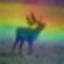

truck
0.397 -> truck
0.363 -> cat
0.062 -> dog
0.059 -> horse
0.038 -> deer


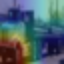

automobile
0.815 -> automobile
0.106 -> truck
0.032 -> cat
0.022 -> frog
0.014 -> ship


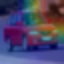

In [88]:
visualize()

The answer to the **question 7** is presented above.